In [1]:
# Install required libraries
!pip install opendatasets --upgrade --quiet
!pip install kaggle --quiet

# Import libraries for downloading the dataset
import opendatasets as od
import os
import random
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.models import Model
import tensorflow as tf
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
import time

# Download dataset from Kaggle
dataset_url = 'https://www.kaggle.com/datasets/nilesh789/eurosat-rgb'
od.download(dataset_url)

# Set the path to the image folder
data_path = '/content/eurosat-rgb/2750'

# Initialize image data and labels
image_data = []
labels = []

# Load the image dataset
for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".jpg"):
            # Read the image
            image = cv2.imread(os.path.join(root, file))
            image = cv2.resize(image, (32, 32))  # Resize
            image = img_to_array(image)
            image_data.append(image)

            # Use the folder name as the label
            label = root.split(os.path.sep)[-1]
            labels.append(label)

# Convert to numpy arrays and normalize the images
image_data = np.array(image_data, dtype="float") / 255.0
labels = np.array(labels)

# Binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)

print(f'Training samples: {len(x_train)}, Testing samples: {len(x_test)}')

# Define the teacher model (more layers)
def teacher_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Define the student model (fewer layers)
def student_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

input_shape = (32, 32, 3)  # Updated input shape
num_classes = len(lb.classes_)  # EuroSAT has 10 classes

# Build teacher and student models
teacher = teacher_model(input_shape, num_classes)
student = student_model(input_shape, num_classes)

# Define a learning rate scheduler function
def lr_scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.1)) if epoch >= 10 else float(lr)

# Compile and train the teacher model
teacher.compile(optimizer=SGD(learning_rate=1e-2, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
teacher.fit(x_train, y_train, batch_size=32, epochs=8, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# Precompute teacher's predictions for distillation
teacher_preds = teacher.predict(x_train)

# Define distillation loss function
def distillation_loss(y_true, y_pred, teacher_preds, temperature=3.0, alpha=0.1):
    teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
    y_true = tf.keras.activations.softmax(y_true / temperature)
    y_pred = tf.keras.activations.softmax(y_pred / temperature)
    teacher_batch_preds = tf.keras.activations.softmax(teacher_batch_preds / temperature)
    soft_loss = tf.keras.losses.categorical_crossentropy(teacher_batch_preds, y_pred)
    hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return alpha * soft_loss + (1. - alpha) * hard_loss

# Compile the student model
student.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds), metrics=['accuracy'])

# Train the student model
student.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# Evaluate the teacher model
teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')

# Generate predictions from the teacher model
teacher_preds_probs = teacher.predict(x_test)
teacher_preds = np.argmax(teacher_preds_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print the classification report for the teacher model
print("=== Teacher Model Classification Report ===")
print(classification_report(y_true, teacher_preds, target_names=lb.classes_))

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: akshayanand2002
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/nilesh789/eurosat-rgb


100%|██████████| 89.6M/89.6M [00:00<00:00, 102MB/s] 



Training samples: 21600, Testing samples: 5400
Epoch 1/8
675/675 ━━━━━━━━━━━━━━━━━━━━ 262s 386ms/step - accuracy: 0.2655 - loss: 1.9060 - val_accuracy: 0.5598 - val_loss: 1.1476 - learning_rate: 0.0100
Epoch 2/8
675/675 ━━━━━━━━━━━━━━━━━━━━ 262s 386ms/step - accuracy: 0.5382 - loss: 1.2292 - val_accuracy: 0.6104 - val_loss: 1.0372 - learning_rate: 0.0100
Epoch 3/8
675/675 ━━━━━━━━━━━━━━━━━━━━ 259s 381ms/step - accuracy: 0.6613 - loss: 0.9326 - val_accuracy: 0.7265 - val_loss: 0.7323 - learning_rate: 0.0100
Epoch 4/8
675/675 ━━━━━━━━━━━━━━━━━━━━ 264s 385ms/step - accuracy: 0.7199 - loss: 0.7977 - val_accuracy: 0.7487 - val_loss: 0.7097 - learning_rate: 0.0100
Epoch 5/8
675/675 ━━━━━━━━━━━━━━━━━━━━ 259s 380ms/step - accuracy: 0.7585 - loss: 0.6816 - val_accuracy: 0.7870 - val_loss: 0.6017 - learning_rate: 0.0100
Epoch 6/8
675/675 ━━━━━━━━━━━━━━━━━━━━ 259s 383ms/step - accuracy: 0.7812 - loss: 0.6058 - val_accuracy: 0.7924 - val_loss: 0.6129 - learning_rate: 0.0100
Epoch 7/8
675/675 ━━━━

In [2]:
# Evaluate models
teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
student_score = student.evaluate(x_test, y_test, verbose=0)
print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')
print(f'Student test accuracy: {student_score[1] * 100:.2f}%')

Teacher test accuracy: 81.30%
Student test accuracy: 81.83%


675/675 ━━━━━━━━━━━━━━━━━━━━ 79s 118ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step
=== Classification Report for Alpha: 0.0 ===
                      precision    recall  f1-score   support

          AnnualCrop       0.82      0.87      0.84       598
              Forest       0.98      0.90      0.94       595
HerbaceousVegetation       0.82      0.81      0.81       606
             Highway       0.80      0.71      0.75       467
          Industrial       0.86      0.97      0.92       528
             Pasture       0.79      0.85      0.82       410
       PermanentCrop       0.81      0.64      0.71       505
         Residential       0.92      0.92      0.92       602
               River       0.77      0.85      0.81       507
             SeaLake       0.91      0.98      0.94       582

            accuracy                           0.85      5400
           macro avg       0.85      0.85      0.85      5400
        weighted avg       0.85      0.85      0.85      5400

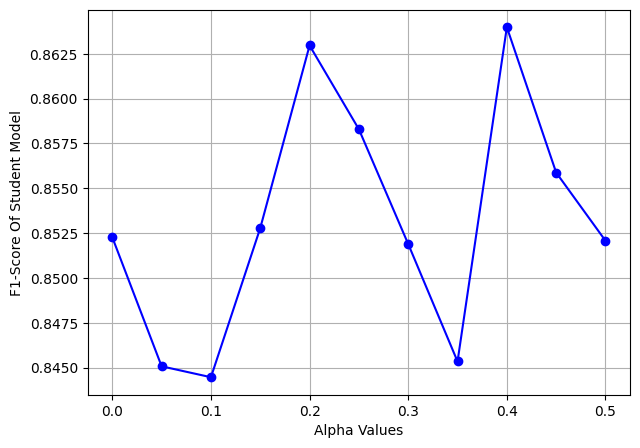

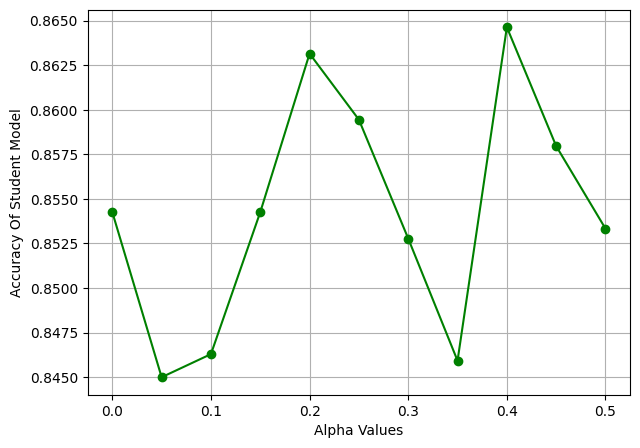

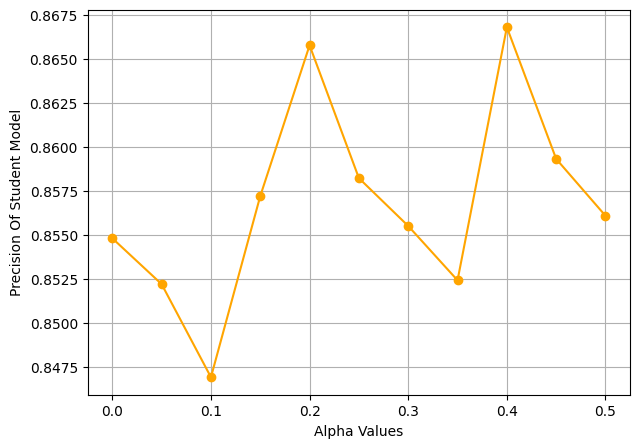

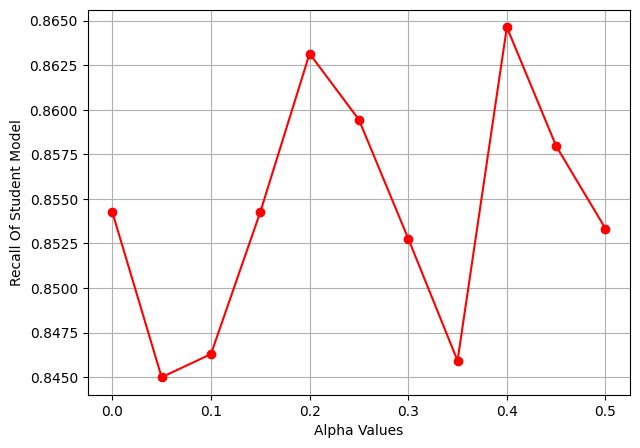

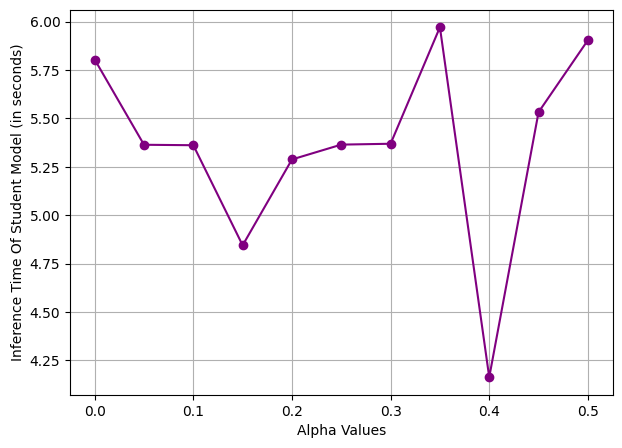

In [3]:
#alpha_values = [0.01, 0.1, 0.2, 0.3, 0.4]
alpha_values = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
f1_scores = []
accuracies = []
precisions = []
recalls = []
inference_times = []

teacher_preds = teacher.predict(x_train)

# Function to evaluate F1-score, accuracy, precision, recall, and inference time for a given model and alpha
def evaluate_student_with_alpha(alpha):
    # Redefine distillation loss function with current alpha
    def distillation_loss(y_true, y_pred, teacher_preds, temperature=3.0, alpha=alpha):
        teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
        y_true = tf.keras.activations.softmax(y_true / temperature)
        y_pred = tf.keras.activations.softmax(y_pred / temperature)
        teacher_batch_preds = tf.keras.activations.softmax(teacher_batch_preds / temperature)
        soft_loss = tf.keras.losses.categorical_crossentropy(teacher_batch_preds, y_pred)
        hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        return alpha * soft_loss + (1. - alpha) * hard_loss

    # Compile the student model with the new distillation loss
    student.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                    loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds),
                    metrics=['accuracy'])

    # Train the student model
    student.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test),
                callbacks=[LearningRateScheduler(lr_scheduler)], verbose=0)

    # Predict and evaluate
    start_time = time.time()
    y_pred_probs = student.predict(x_test)
    inference_time = time.time() - start_time
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate and store F1-score, accuracy, precision, recall, and inference time
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    # Append the results
    f1_scores.append(f1)
    accuracies.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    inference_times.append(inference_time)

    # Print classification report
    print(f"=== Classification Report for Alpha: {alpha} ===")
    print(classification_report(y_true, y_pred, target_names=lb.classes_))
    print(f"Inference Time: {inference_time:.4f} seconds\n")
    print(f"Alpha: {alpha} - F1 Score: {f1:.4f}, Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# Run evaluation for each alpha
for alpha in alpha_values:
    evaluate_student_with_alpha(alpha)

# Plot F1-Score vs. Alpha
plt.figure(figsize=(7, 5))
plt.plot(alpha_values, f1_scores, marker='o', color='b')
plt.xlabel("Alpha Values")
plt.ylabel("F1-Score Of Student Model")
plt.grid(True)
plt.savefig("f1_score_vs_alpha.pdf")
plt.show()

# Plot Accuracy vs. Alpha
plt.figure(figsize=(7, 5))
plt.plot(alpha_values, accuracies, marker='o', color='g')
plt.xlabel("Alpha Values")
plt.ylabel("Accuracy Of Student Model")
plt.grid(True)
plt.savefig("accuracy_vs_alpha.pdf")
plt.show()

# Plot Precision vs. Alpha
plt.figure(figsize=(7, 5))
plt.plot(alpha_values, precisions, marker='o', color='orange')
plt.xlabel("Alpha Values")
plt.ylabel("Precision Of Student Model")
plt.grid(True)
plt.savefig("precision_vs_alpha.pdf")
plt.show()

# Plot Recall vs. Alpha
plt.figure(figsize=(7, 5))
plt.plot(alpha_values, recalls, marker='o', color='red')
plt.xlabel("Alpha Values")
plt.ylabel("Recall Of Student Model")
plt.grid(True)
plt.savefig("recall_vs_alpha.pdf")
plt.show()

# Plot Inference Time vs. Alpha
plt.figure(figsize=(7, 5))
plt.plot(alpha_values, inference_times, marker='o', color='purple')
plt.xlabel("Alpha Values")
plt.ylabel("Inference Time Of Student Model (in seconds)")
plt.grid(True)
plt.savefig("inference_time_vs_alpha.pdf")
plt.show()